<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Flask_Yolo_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tạo môi trường để sử dung Yolo
!pip install opencv-python==4.4.0.46 -i https://pypi.douban.com/simple

Looking in indexes: https://pypi.douban.com/simple


In [2]:
#Thư viện web trên colab
!pip install flask-ngrok

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [5]:
#608X608
# load in our YOLOv4 architecture network
from darknet import *
from Function import *
network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

In [6]:
#Hàm detection people
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [7]:
#Hiện thị ảnh Detection.(DÙNG ĐỂ TEST)
def Detection(detections,image):
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  cv2_imshow(image)

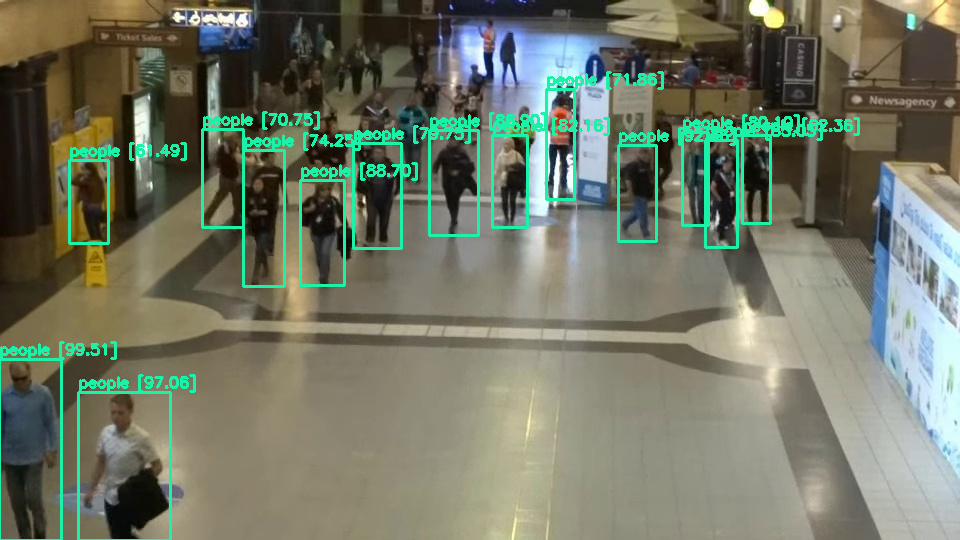

In [8]:
image = cv2.imread("/content/MOT20_02_raw_frame_100.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
boxes = [bbox for _,_,bbox in detections]
Detection(detections,image)

In [9]:
original_image_BGR = cv2.imread('/content/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


In [10]:
src = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])
dst_size=(800,1080)
def H_matrix(src,dst,dst_size):
  dst = dst * np.float32(dst_size)
  H_matrix = cv2.getPerspectiveTransform(src, dst)
  return H_matrix
H_matrix=H_matrix(src,dst,dst_size)




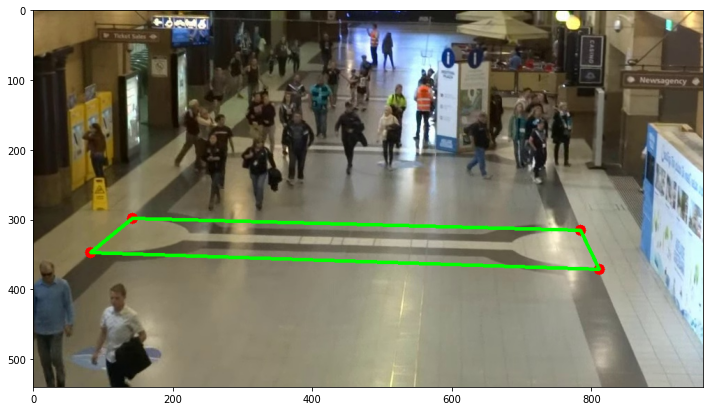

In [11]:
Draw_Point4(original_image_RGB_copy,src)

In [12]:
#3 Point để tính distance pixel image so với thực tế
pts= np.float32([[[252., 314.],
                  [323., 316.],
                  [238., 347.]]])
distance_w,distance_h=distance_pixel(pts,H_matrix)
print(distance_w,distance_h)

53.438141060012626 35.74068208542818


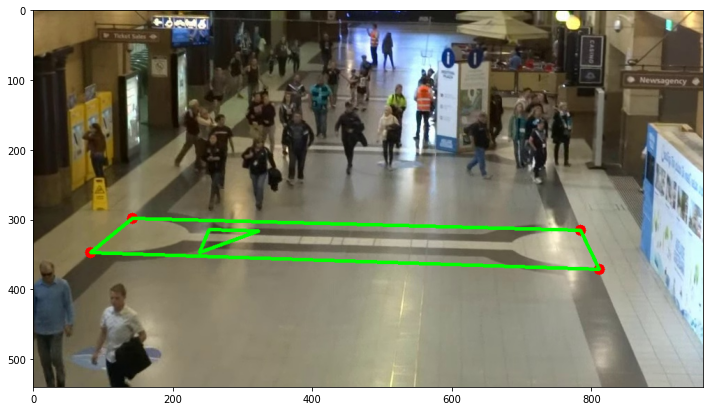

In [13]:
#Visualize
Draw_Point3(original_image_RGB_copy,pts)

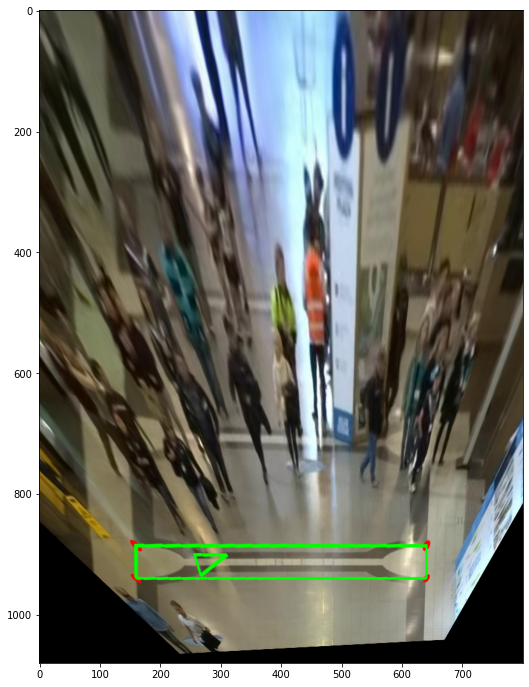

In [14]:
#Chuyển đổi matrix camera
Perspective(original_image_RGB_copy,H_matrix,dst_size)

In [15]:
#Tính Position People sau khi chuyển đổi qua bird-eye 
birds_eye_points=Point_transform(H_matrix,boxes)

In [16]:
min_distance = 120
green_box,red_box=get_red_green_boxes_1(min_distance,birds_eye_points,boxes,distance_w,distance_h)

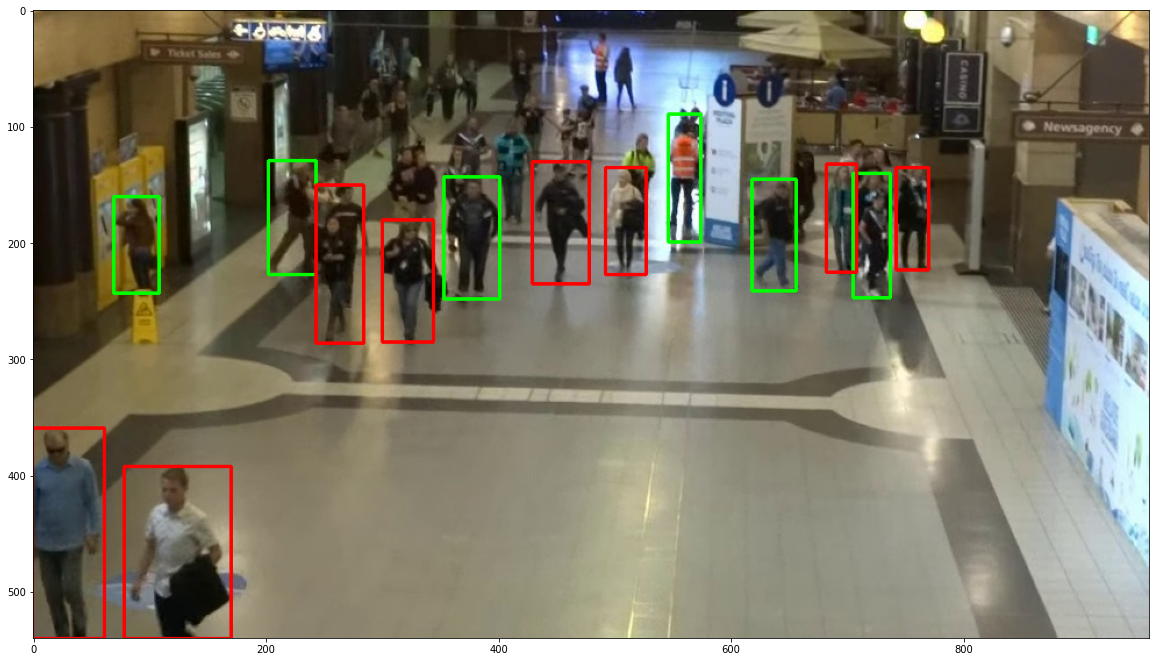

In [17]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box,width_ratio,height_ratio)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

In [18]:
#Chuyển đổi lên map bird-eye-view
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)

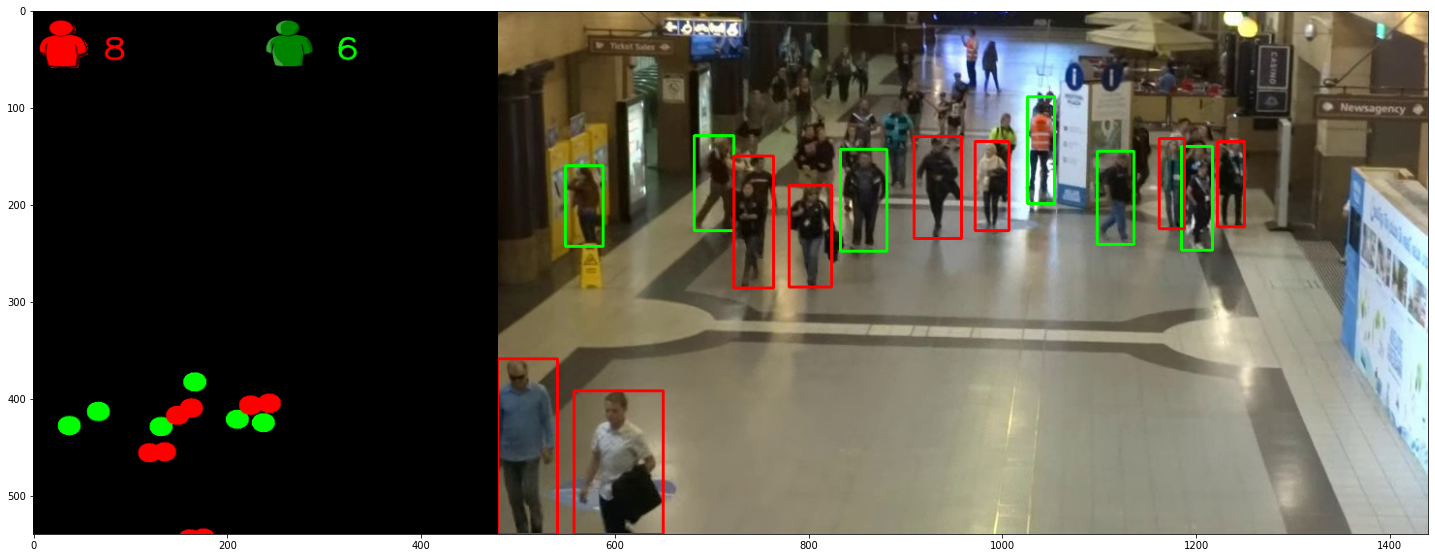

In [19]:
#Nối 2 ảnh đã handle
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
plt.show()

In [20]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, Response
import cv2
import sys
from imutils.video import FPS
from imutils.video import FileVideoStream

app=Flask(__name__,template_folder="/content/templates")
run_with_ngrok(app)

@app.route('/')
def index():
    """Video streaming home page."""
    return render_template('index.html')
H_matrix_flask=H_matrix
distance_h_flask=distance_h
distance_w_flask=distance_w
width_flask=width
height_flask=height
image_height_flask=image_height
image_width_flask=image_width
video = FileVideoStream('/content/People2_Trim.mp4').start()
def gen(H_matrix_flask,distance_w_flask,distance_h_flask,width_flask,height_flask,image_height_flask,image_width_flask):
    frame_number = 0
    print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
    """Video streaming generator function."""
    # Read until video is completed
    min_distance=180
    while video.more():
        frame = video.read()
        detections, width_ratio, height_ratio = darknet_helper(frame, width_flask, height_flask)
        boxes = [bbox for _,_,bbox in detections]
        birds_eye_points = Point_transform(H_matrix_flask, boxes)
        green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w_flask,distance_h_flask)
        birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height_flask,eye_view_width=image_width_flask//2)
        box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

        combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
          
        frame = cv2.imencode('.jpg', combined_image)[1].tobytes()
        yield (b'--frame\r\n'b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
        del detections,combined_image,birds_eye_view_image
        #time.sleep(0.1)
        # del detections,combined_image,birds_eye_view_image
        key = cv2.waitKey(30)
        if key == 27:
           break   
@app.route('/video_feed')
def video_feed():
    """Video streaming route. Put this in the src attribute of an img tag."""
    return Response(gen(H_matrix_flask,distance_w_flask,distance_h_flask,width_flask,height_flask,image_height_flask,image_width_flask),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://17411a8615ed.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Jun/2021 08:11:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jun/2021 08:11:12] "GET /video_feed HTTP/1.1" 200 -


Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person      


Error on request:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/werkzeug/serving.py", line 323, in run_wsgi
    execute(self.server.app)
  File "/usr/local/lib/python3.7/dist-packages/werkzeug/serving.py", line 314, in execute
    for data in application_iter:
  File "/usr/local/lib/python3.7/dist-packages/werkzeug/wsgi.py", line 506, in __next__
    return self._next()
  File "/usr/local/lib/python3.7/dist-packages/werkzeug/wrappers/base_response.py", line 45, in _iter_encoded
    for item in iterable:
  File "<ipython-input-20-fccfc6122ae7>", line 31, in gen
    
  File "<ipython-input-6-b44b0fb5a5e6>", line 4, in darknet_helper
    
cv2.error: OpenCV(4.4.0) /tmp/pip-req-build-cg56sov1/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [21]:
import sys
video = cv2.VideoCapture('/content/People2_Trim.mp4')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
while True:
  
  ret,frame = video.read()

  if not ret:
    break
  detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
  boxes = [bbox for _,_,bbox in detections]
  birds_eye_points = Point_transform(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w,distance_h)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)

  frame_number += 1
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i\n' % (frame_number,len(boxes),len(red_box),len(green_box)))

  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('/content/test.avi', fourcc, 15, (combined_image.shape[1], combined_image.shape[0]), True)

  writer.write(combined_image)

  del detections,combined_image,birds_eye_view_image

print(' ')
writer.release()
video.release()

Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person      
1                   |17                       |8                        |9                        
2                   |17                       |10                       |7                        
3                   |17                       |10                       |7                        
4                   |17                       |10                       |7                        
5                   |17                       |10                       |7                        
6                   |18                       |10                       |8                        
7                   |18                       |10                       |8                        
8                   |20                       |10                       |10                       
9                   |20                       |12                       |8                        
10        